In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline


In [3]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving reviews_clean.csv to reviews_clean (1).csv


In [4]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['reviews_clean.csv']))

In [5]:
data.head()

,Unnamed: 0,Hotel_id,Hotel,Address,City,Title,Users,Reviews,Rating,Hotel_Type,Price,Hotel_Category,User_id,Sentiment,Label,Text_Clean,lemmatized,polarity
0,0,0,La Quinta,5820 Walden Rd,Beaumont,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,1,2,Rs.8989,"Lodging,Motels,Hotels,Meeting & Event Planning...",15400,Negative,0,this hotel is a dump upon checking in was told...,hotel dump check tell place book folk run isaa...,0.188788
1,1,2,Inn At Queen Anne,505 1st Ave N,Seattle,Me and the little mouse,A Traveler2,Hope you are strong enough to carry all bags u...,2,2,Rs.8457,"hotel,Hotels",17618,Negative,0,hope you are strong enough to carry all bags u...,hope strong carry bag upstairs elevator coffee...,0.091667
2,2,2,Inn At Queen Anne,505 1st Ave N,Seattle,Unique hotel with character,A Traveler23,My boyfriend and I decided to stay at this hot...,4,2,Rs.8457,"hotel,Hotels",17602,Positive,1,my boyfriend and i decided to stay at this hot...,boyfriend decide stay hotel half price good ho...,0.258333
3,3,2,Inn At Queen Anne,505 1st Ave N,Seattle,Would stay again.,A Traveler22,The hotel was quaint and had a pleasant vibe t...,4,2,Rs.8457,"hotel,Hotels",17601,Positive,1,the hotel was quaint and had a pleasant vibe t...,hotel quaint pleasant vibe good size,0.716667
4,4,2,Inn At Queen Anne,505 1st Ave N,Seattle,Never Again!,A Traveler21,"Dirty, run down, poorly represented, nothing l...",1,2,Rs.8457,"hotel,Hotels",17600,Negative,0,dirty run down poorly represented nothing like...,dirty run poorly represent like picture descri...,-0.500000


In [6]:
# Checking for missing values
pd.isnull(data).any()

Unnamed: 0        False
Hotel_id          False
Hotel             False
Address           False
City              False
Title             False
Users             False
Reviews           False
Rating            False
Hotel_Type        False
Price             False
Hotel_Category    False
User_id           False
Sentiment         False
Label             False
Text_Clean         True
lemmatized         True
polarity          False
dtype: bool

In [7]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (11998, 18)
Index(['Unnamed: 0', 'Hotel_id', 'Hotel', 'Address', 'City', 'Title', 'Users',
       'Reviews', 'Rating', 'Hotel_Type', 'Price', 'Hotel_Category', 'User_id',
       'Sentiment', 'Label', 'Text_Clean', 'lemmatized', 'polarity'],
      dtype='object')
No. of unique classes 2


In [8]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [9]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [10]:
macronum=sorted(set(data['Label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Label']=data['Label'].apply(fun)

In [11]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Label']:
    labels.append(idx)

In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 26390


In [13]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (11998, 1000)
Shape of Label Tensor: (11998, 2)


In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-10 12:38:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-10 12:38:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-10 12:38:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [15]:
!unzip glove*.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [16]:
!ls
!pwd

 glove.6B.100d.txt   glove.6B.50d.txt	      reviews_clean.csv
 glove.6B.200d.txt   glove.6B.zip	      sample_data
 glove.6B.300d.txt  'reviews_clean (1).csv'
/content


In [17]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [18]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [20]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         2639100   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 2,800,302
Trainable params: 2,800,302
Non-trainable params: 0
_________________________________________________________________


In [21]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=7, batch_size=32,callbacks=[cp])

Epoch 1/7
300/300 [==============================] - ETA: 0s - loss: 0.4719 - acc: 0.7941
Epoch 00001: val_acc improved from -inf to 0.84118, saving model to model_rnn.hdf5
300/300 [==============================] - 488s 2s/step - loss: 0.4719 - acc: 0.7941 - val_loss: 0.3838 - val_acc: 0.8412
Epoch 2/7
300/300 [==============================] - ETA: 0s - loss: 0.3625 - acc: 0.8477
Epoch 00002: val_acc improved from 0.84118 to 0.85160, saving model to model_rnn.hdf5
300/300 [==============================] - 482s 2s/step - loss: 0.3625 - acc: 0.8477 - val_loss: 0.3473 - val_acc: 0.8516
Epoch 3/7
300/300 [==============================] - ETA: 0s - loss: 0.3076 - acc: 0.8717
Epoch 00003: val_acc improved from 0.85160 to 0.85452, saving model to model_rnn.hdf5
300/300 [==============================] - 484s 2s/step - loss: 0.3076 - acc: 0.8717 - val_loss: 0.3471 - val_acc: 0.8545
Epoch 4/7
300/300 [==============================] - ETA: 0s - loss: 0.2705 - acc: 0.8903
Epoch 00004: val_ac

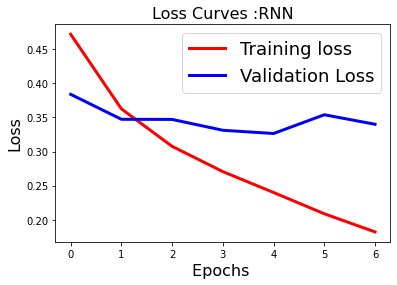

In [22]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

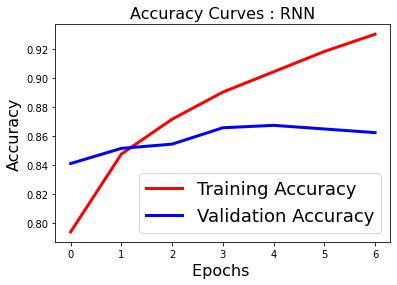

In [23]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

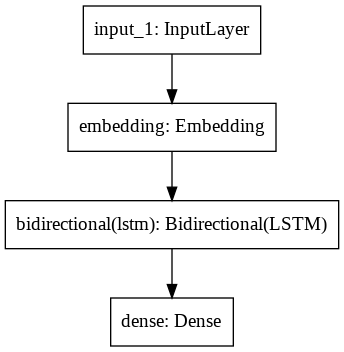

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='rnn_model.png')